In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import parquet
import os

from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from os import mkdir, listdir
from os.path import join
import numpy as np
from pickle import load, dump


pd.set_option('display.max_columns', 200)

In [16]:
df = pd.read_csv(r'C:\Users\tyler\OneDrive\Desktop\PhD Stuff\STA 6366\Final Project\cleaned_steamDB2.csv')

C:\Users\tyler\AppData\Local\Temp\ipykernel_1800\3712476406.py:1: DtypeWarning: Columns (11,12,21,23,27,28,30,31,32,33,34,35,37,38,44,45,49,50,52,53,54,55,56,58,60,61,62,63,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,

In [4]:
dev_cols = df.filter(like='dev_')
df['developer'] = dev_cols.apply(lambda row: ', '.join(str(cell) for cell in row if cell), axis=1)

In [5]:
pub_cols = df.filter(like='pub_')
df['publisher'] = pub_cols.apply(lambda row: ', '.join(str(cell) for cell in row if cell), axis=1)

In [7]:
developer_names = []
publisher_names = []

In [8]:
for index, row in df.iterrows():
    dev_names = [col.split('_')[1] for col in df.columns if col.startswith('dev_') and row[col] == 1]
    pub_names = [col.split('_')[1] for col in df.columns if col.startswith('pub_') and row[col] == 1]

    developer_names.append(', '.join(dev_names))
    publisher_names.append(', '.join(pub_names))

In [9]:
df['developer'] = developer_names
df['publisher'] = publisher_names

In [11]:
columns_to_drop = [col for col in df.columns if col.startswith('dev_') or col.startswith('pub_')]
df = df.drop(columns=columns_to_drop)

In [13]:
df

,Unnamed: 0,appid,Name,Pos_Reviews,Neg_Reviews,Tot_Reviews,all-time_peak_ccu,last_30_days_avg_ccu,game_name,dlc,price,f2p,unavailable,steam_deck_status,metacritic_score,release_date,esrbRating,storage,memory,curators,steam_achievements,Single-player,Online Co-op,Shared/Split Screen Co-op,Steam Achievements,Full controller support,Steam Trading Cards,Captions available,Steam Workshop,Steam Cloud,Stats,Includes level editor,Commentary available,Remote Play on Phone,Remote Play on Tablet,Remote Play on TV,Remote Play Together,genre_Action,genre_Adventure,paidDLCs,DLCs,totDLCPrice,genre_Casual,genre_Indie,genre_Simulation,genre_RPG,LAN Co-op,Partial Controller Support,Includes Source SDK,Online PvP,genre_Strategy,Tracked Controller Support,VR Only,Valve Anti-Cheat enabled,Profile Features Limited,genre_Early Access,Steam Leaderboards,VR Supported,genre_Free to Play,In-App Purchases,Shared/Split Screen PvP,LAN PvP,Cross-Platform Multiplayer,genre_Racing,genre_Massively Multiplayer,genre_Sports,SteamVR Collectibles,MMO,Steam Turn Notifications,Steam is learning about this game,Game demo,genre_Audio Production,genre_Design & Illustration,Mods,Mods (require HL2),Downloadable Content,numUpdates,lastUpdate,Support interface,Support full audio,Support subtitles,Tags,developer,publisher
0,0,620,Portal 2,358880,4571,363451,14984.0,5869.0,Portal 2,1.0,9.99,False,False,NaN,95.0,"Apr 18, 2011",NaN,8 GB,2 GB,3930.0,51.0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,0.0,1.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,1.682533e+09,27.0,5.0,27.0,"Platformer, Puzzle, Dark Humor, First-Person, ...",Valve,Valve
1,1,1118200,People Playground,211277,2723,214000,15643.0,15643.0,People Playground,0.0,9.99,False,False,NaN,NaN,"Jul 23, 2019",NaN,350 MB,4 GB,344.0,17.0,True,NaN,NaN,True,NaN,True,NaN,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,0.0,0.0,0.00,True,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.0,1.691801e+09,1.0,0.0,0.0,"Sandbox, Gore, Physics, Blood, Violent",mestiez,Studio Minus
2,2,1794680,Vampire Survivors,208300,2928,211228,77061.0,12070.0,Vampire Survivors,3.0,4.99,False,False,NaN,87.0,"Oct 20, 2022",NaN,600 MB,1 GB,680.0,196.0,True,NaN,NaN,True,True,True,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,True,True,NaN,3.0,3.0,5.97,True,True,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,1.694679e+09,12.0,0.0,0.0,"Action Roguelike, Bullet Hell, Pixel Graphics,...",poncle,poncle
3,3,413150,Stardew Valley,597498,10823,608321,94479.0,48881.0,Stardew Valley,1.0,14.99,False,False,NaN,89.0,"Feb 26, 2016",e10,500 MB,2 GB,2548.0,40.0,True,True,True,True,True,True,NaN,NaN,True,NaN,NaN,NaN,True,True,NaN,True,NaN,NaN,1.0,1.0,4.99,NaN,True,True,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,1.640117e+09,12.0,0.0,0.0,"Pixel Graphics, Farming Sim, Life Sim, Multipl...",ConcernedApe,ConcernedApe
4,4,1145360,Hades,231236,3554,234790,37586.0,6541.0,Hades,1.0,24.99,False,False,NaN,93.0,"Sep 17, 2020",t,15 GB,4 GB,947.0,49.0,True,NaN,NaN,NaN,True,True,True,NaN,True,NaN,NaN,NaN,True,True,True,NaN,True,NaN,0.0,1.0,0.00,NaN,True,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,1.644963e+09,11.0,1.0,11.0,"Action Roguelike, Roguelite, Hack and Slash, I...",Supergiant Games,Supergiant Games
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [12]:
df.columns

Index(['Unnamed: 0', 'appid', 'Name', 'Pos_Reviews', 'Neg_Reviews',
       'Tot_Reviews', 'all-time_peak_ccu', 'last_30_days_avg_ccu', 'game_name',
       'dlc', 'price', 'f2p', 'unavailable', 'steam_deck_status',
       'metacritic_score', 'release_date', 'esrbRating', 'storage', 'memory',
       'curators', 'steam_achievements', 'Single-player', 'Online Co-op',
       'Shared/Split Screen Co-op', 'Steam Achievements',
       'Full controller support', 'Steam Trading Cards', 'Captions available',
       'Steam Workshop', 'Steam Cloud', 'Stats', 'Includes level editor',
       'Commentary available', 'Remote Play on Phone', 'Remote Play on Tablet',
       'Remote Play on TV', 'Remote Play Together', 'genre_Action',
       'genre_Adventure', 'paidDLCs', 'DLCs', 'totDLCPrice', 'genre_Casual',
       'genre_Indie', 'genre_Simulation', 'genre_RPG', 'LAN Co-op',
       'Partial Controller Support', 'Includes Source SDK', 'Online PvP',
       'genre_Strategy', 'Tracked Controller Support', '

In [14]:
df.to_csv('EDA_ready_data.csv', index=False)  # Use your desired filename

print("CSV file exported.")

CSV file exported.


In [21]:
df.to_parquet('CleanedData.parquet', engine = 'fastparquet')

In [34]:
df = pd.read_parquet('./CleanedData.parquet', engine = 'fastparquet')

In [36]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None) 

In [37]:
df.isna().sum()

Unnamed: 0                               0
appid                                    0
Name                                     0
Pos_Reviews                              0
Neg_Reviews                              0
Tot_Reviews                              0
all-time_peak_ccu                     2559
last_30_days_avg_ccu                  2559
game_name                                1
dlc                                      1
price                                 2027
f2p                                      1
unavailable                              1
steam_deck_status                    10478
metacritic_score                      8799
release_date                            30
esrbRating                            7859
storage                               1425
memory                                 470
curators                                16
steam_achievements                    2637
Single-player                          599
Online Co-op                          9219
Shared/Spli

In [38]:
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

In [40]:
missing_values = df.isna().sum()

# Get the column names with more than 10,000 missing values
columns_to_drop = missing_values[missing_values > len(df) - 20].index

# Drop the columns with more than 10,000 missing values
df = df.drop(columns=columns_to_drop)

In [41]:
df.shape

(10478, 76)

In [42]:
df = df.set_index("Name")

In [44]:
df = df.sort_values(by="Pos_Reviews", ascending = False)

In [47]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None) 

In [48]:
df['developer'].value_counts()

KOEI TECMO GAMES CO., LTD.                                                                                                                                                                                                                                  52
CAPCOM Co., Ltd.                                                                                                                                                                                                                                            34
Square Enix                                                                                                                                                                                                                                                 33
Valve                                                                                                                                                                                                                                      

In [49]:
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

Text(0, 0.5, 'Developer')

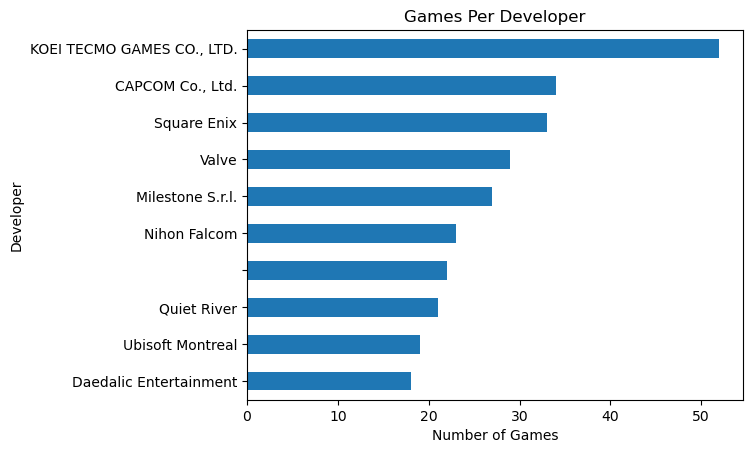

In [50]:
ax = df['developer'].value_counts() \
    .head(10) \
    .plot.barh(title = 'Games Per Developer')
ax.invert_yaxis()
ax.set_xlabel("Number of Games")
ax.set_ylabel("Developer")

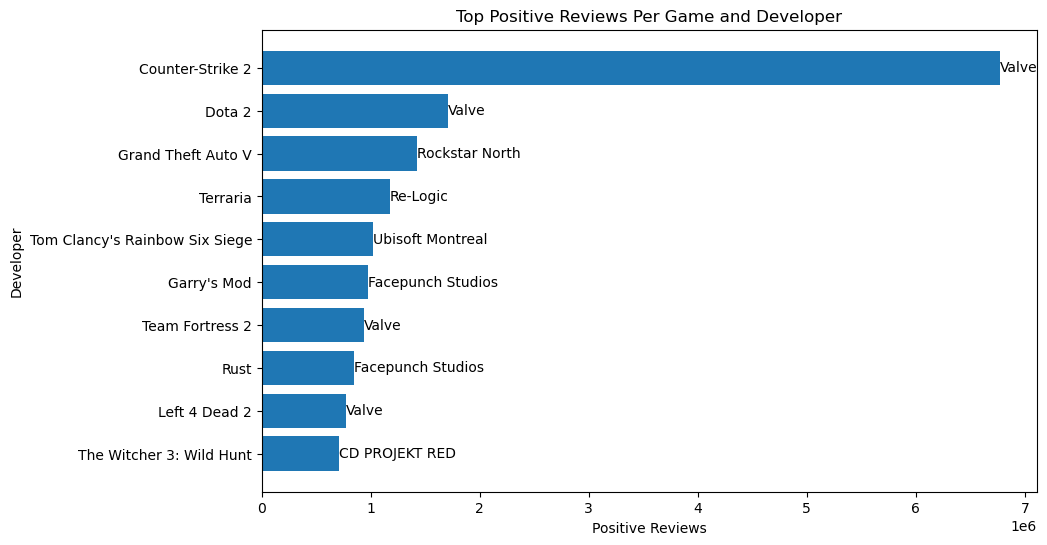

In [51]:
df_reset = df.reset_index()
df_first_10 = df_reset.head(10)

fig, ax = plt.subplots(figsize=(10,6))
bars = ax.barh(df_first_10['Name'], df_first_10['Pos_Reviews'], align='center')
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Positive Reviews')
ax.set_ylabel("Developer")
ax.set_title('Top Positive Reviews Per Game and Developer')

# Add developer names on the right side of the bars
for bar, name in zip(bars, df_first_10['developer']):
    ax.annotate(name, xy=(bar.get_width(), bar.get_y() + bar.get_height() / 2), va='center')

plt.show()

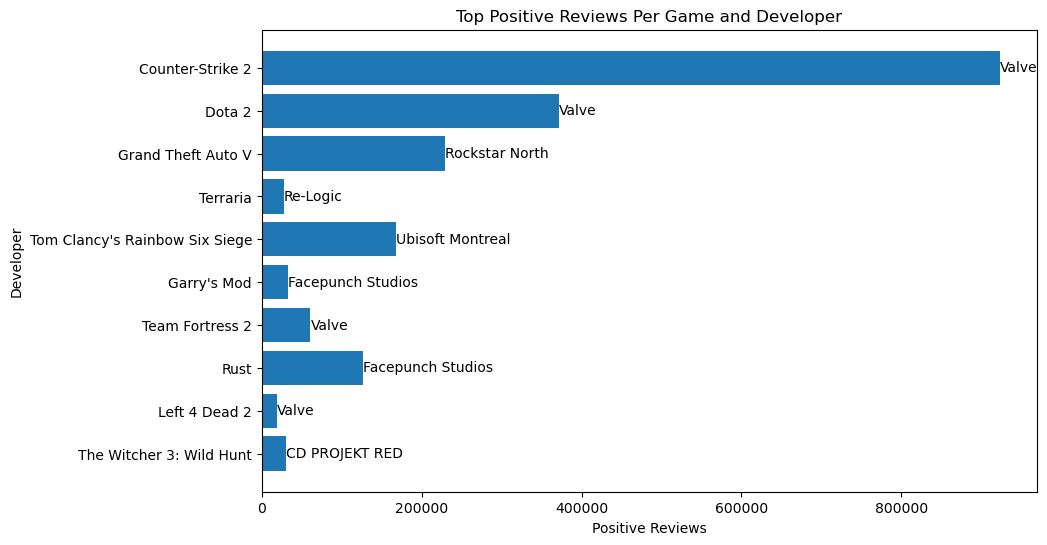

In [52]:
df_reset = df.reset_index()
df_first_10 = df_reset.head(10)

fig, ax = plt.subplots(figsize=(10,6))
bars = ax.barh(df_first_10['Name'], df_first_10['Neg_Reviews'], align='center')
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Positive Reviews')
ax.set_ylabel("Developer")
ax.set_title('Top Positive Reviews Per Game and Developer')

# Add developer names on the right side of the bars
for bar, name in zip(bars, df_first_10['developer']):
    ax.annotate(name, xy=(bar.get_width(), bar.get_y() + bar.get_height() / 2), va='center')

plt.show()

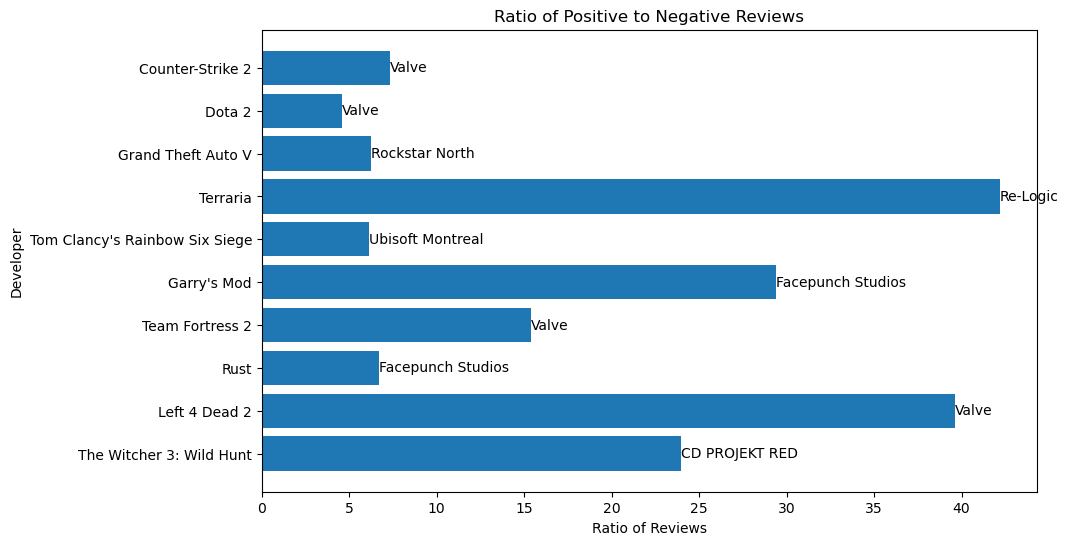

In [53]:
df_reset = df.reset_index()
df_first_10 = df_reset.head(10)

fig, ax = plt.subplots(figsize=(10,6))
bars = ax.barh(df_first_10['Name'], df_first_10['Pos_Reviews'] /  df_first_10['Neg_Reviews'], align='center')
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Ratio of Reviews')
ax.set_ylabel("Developer")
ax.set_title('Ratio of Positive to Negative Reviews')

# Add developer names on the right side of the bars
for bar, name in zip(bars, df_first_10['developer']):
    ax.annotate(name, xy=(bar.get_width(), bar.get_y() + bar.get_height() / 2), va='center')

plt.show()

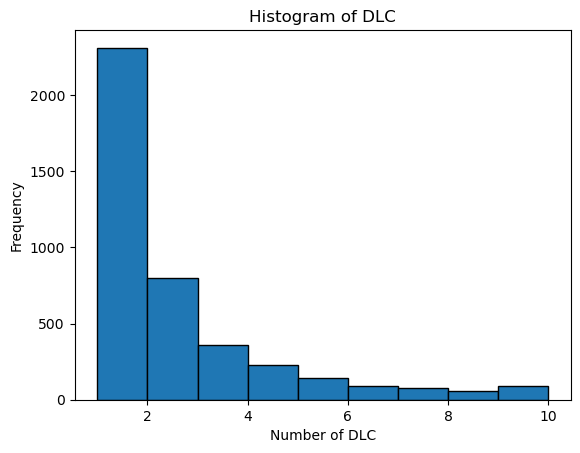

In [54]:
dlc_data = df['dlc']  # Extract the 'dlc' column

filtered_data = dlc_data[(dlc_data >= 1) & (dlc_data <= 10)]

# Create the histogram
plt.hist(filtered_data, bins=9, range=(1, 10), edgecolor='black')

plt.xlabel('Number of DLC')
plt.ylabel('Frequency')
plt.title('Histogram of DLC')
plt.show()

C:\Users\tyler\AppData\Local\Temp\ipykernel_25064\116069942.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(filtered_data, shade=True, color="blue")


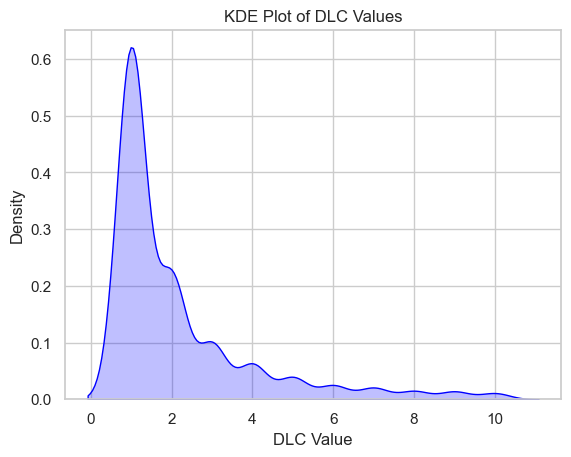

In [55]:
dlc_data = df['dlc']

# Filter data within the desired range (1-10)
filtered_data = dlc_data[(dlc_data >= 1) & (dlc_data <= 10)]

# Create the KDE plot
sns.set(style="whitegrid")
sns.kdeplot(filtered_data, shade=True, color="blue")

plt.xlabel('DLC Value')
plt.ylabel('Density')
plt.title('KDE Plot of DLC Values')
plt.show()

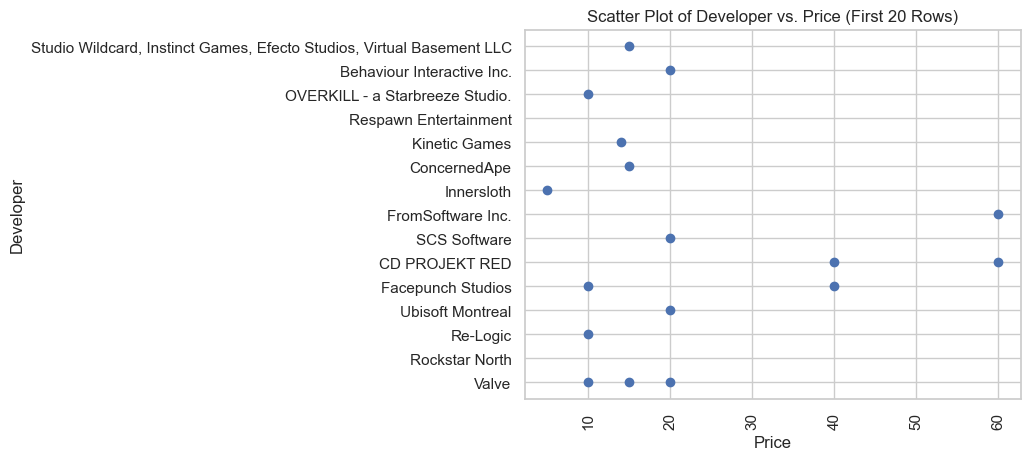

In [56]:
df_first_20 = df.head(20)

plt.scatter(df_first_20['price'], df_first_20['developer'])
plt.xlabel('Price')
plt.ylabel('Developer')
plt.title('Scatter Plot of Developer vs. Price (First 20 Rows)')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility

plt.show()

In [57]:
df.columns

Index(['Unnamed: 0', 'appid', 'Pos_Reviews', 'Neg_Reviews', 'Tot_Reviews',
       'all-time_peak_ccu', 'last_30_days_avg_ccu', 'game_name', 'dlc',
       'price', 'f2p', 'unavailable', 'metacritic_score', 'release_date',
       'esrbRating', 'storage', 'memory', 'curators', 'steam_achievements',
       'Single-player', 'Online Co-op', 'Shared/Split Screen Co-op',
       'Steam Achievements', 'Full controller support', 'Steam Trading Cards',
       'Captions available', 'Steam Workshop', 'Steam Cloud', 'Stats',
       'Includes level editor', 'Commentary available', 'Remote Play on Phone',
       'Remote Play on Tablet', 'Remote Play on TV', 'Remote Play Together',
       'genre_Action', 'genre_Adventure', 'paidDLCs', 'DLCs', 'totDLCPrice',
       'genre_Casual', 'genre_Indie', 'genre_Simulation', 'genre_RPG',
       'LAN Co-op', 'Partial Controller Support', 'Includes Source SDK',
       'Online PvP', 'genre_Strategy', 'Tracked Controller Support', 'VR Only',
       'Valve Anti-Cheat e

In [58]:
df['memory'].dtype

dtype('O')

In [59]:
df['storage'] = pd.to_numeric(df['storage'].str.extract('(\d+)', expand=False), errors='coerce', downcast='integer')

In [60]:
df['memory'] = pd.to_numeric(df['memory'].str.extract('(\d+)', expand=False), errors='coerce', downcast='integer')

In [61]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [65]:
df

,Unnamed: 0,appid,Pos_Reviews,Neg_Reviews,Tot_Reviews,all-time_peak_ccu,last_30_days_avg_ccu,game_name,dlc,price,...,MMO,Steam Turn Notifications,numUpdates,lastUpdate,Support interface,Support full audio,Support subtitles,Tags,developer,publisher
Name,,,,,,,,,,,,,,,,,,,,,
Counter-Strike 2,2551,730,6770741,923273,7694014,1802853.0,1405839.0,Counter-Strike 2,0.0,14.99,...,NaN,NaN,68.0,1.698269e+09,28.0,1.0,0.0,"[Multiplayer, Action, FPS, Shooter, Competitive]",Valve,Valve
Dota 2,5428,570,1706328,371431,2077759,1291328.0,760096.0,Dota 2,2.0,NaN,...,NaN,NaN,65.0,1.697178e+09,28.0,3.0,0.0,"[Multiplayer, Strategy, Free to Play, eSports,...",Valve,Valve
Grand Theft Auto V,3567,271590,1428291,229164,1657455,360761.0,166618.0,Grand Theft Auto V,2.0,NaN,...,NaN,NaN,0.0,0.000000e+00,13.0,1.0,13.0,"[Multiplayer, Action, Open World, Automobile S...",Rockstar North,Rockstar Games
Terraria,6,105600,1176177,27878,1204055,486918.0,63954.0,Terraria,2.0,9.99,...,NaN,NaN,2.0,1.479232e+09,9.0,0.0,0.0,"[Sandbox, 2D, Multiplayer, Open World Survival...",Re-Logic,Re-Logic
Tom Clancy's Rainbow Six Siege,3704,359550,1023549,167281,1190830,199830.0,94953.0,Tom Clancy's Rainbow Six® Siege,9.0,19.99,...,NaN,NaN,34.0,1.688659e+09,16.0,8.0,15.0,"[Multiplayer, FPS, Shooter, PvP, eSports]",Ubisoft Montreal,Ubisoft
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Diesel Guns,10211,355400,211,91,302,NaN,NaN,Diesel Guns,0.0,7.99,...,NaN,NaN,17.0,1.558101e+09,4.0,4.0,4.0,"[Automobile Sim, Early Access, Arena Shooter, ...",LLC Intenzibne,LLC Intenzibne
World of Talesworth: Idle MMO Simulator,10212,1177970,211,91,302,1876.0,62.0,World of Talesworth: Idle MMO Simulator,0.0,NaN,...,NaN,NaN,11.0,1.666745e+09,1.0,0.0,0.0,"[Pixel Graphics, Singleplayer, Simulation, Adv...",Talesworth Game Studio,Talesworth Game Studio
Chronicles of Teddy,10315,341020,211,94,305,NaN,NaN,Chronicles of Teddy,1.0,14.99,...,NaN,NaN,6.0,1.459340e+09,17.0,0.0,17.0,"[Indie, Action, Female Protagonist, Adventure,...",Storybird,"Plug In Digital, LookAtMyGame"


In [89]:
# Convert the string representation to a list of tags
df['Tags'] = df['Tags'].str.split(', ')

# Create binary columns for each unique tag
tag_dummies = pd.get_dummies(df['Tags'].apply(pd.Series).stack()).sum(level=0)

# Concatenate the original DataFrame with the binary tag columns
df = pd.concat([df, tag_dummies], axis=1)

df = df.drop(columns=['Tags'])

C:\Users\tyler\AppData\Local\Temp\ipykernel_25064\2508124526.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  tag_dummies = pd.get_dummies(df['Tags'].apply(pd.Series).stack()).sum(level=0)
C:\Users\tyler\AppData\Local\Temp\ipykernel_25064\2508124526.py:5: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  tag_dummies = pd.get_dummies(df['Tags'].apply(pd.Series).stack()).sum(level=0)


In [101]:
df['storage'] = pd.to_numeric(df['storage'].str.extract('(\d+)', expand=False), errors='coerce', downcast='integer')

In [102]:
df['memory'] = pd.to_numeric(df['memory'].str.extract('(\d+)', expand=False), errors='coerce', downcast='integer')

In [103]:
pd.reset_option('display.max_rows')

In [104]:
pd.set_option('display.max_columns', None)
df.head(5)

,Unnamed: 0,appid,Name,Pos_Reviews,Neg_Reviews,Tot_Reviews,all-time_peak_ccu,last_30_days_avg_ccu,game_name,dlc,price,f2p,unavailable,steam_deck_status,metacritic_score,release_date,esrbRating,storage,memory,curators,steam_achievements,Single-player,Online Co-op,Shared/Split Screen Co-op,Steam Achievements,Full controller support,Steam Trading Cards,Captions available,Steam Workshop,Steam Cloud,Stats,Includes level editor,Commentary available,Remote Play on Phone,Remote Play on Tablet,Remote Play on TV,Remote Play Together,genre_Action,genre_Adventure,paidDLCs,DLCs,totDLCPrice,genre_Casual,genre_Indie,genre_Simulation,genre_RPG,LAN Co-op,Partial Controller Support,Includes Source SDK,Online PvP,genre_Strategy,Tracked Controller Support,VR Only,Valve Anti-Cheat enabled,Profile Features Limited,genre_Early Access,Steam Leaderboards,VR Supported,genre_Free to Play,In-App Purchases,Shared/Split Screen PvP,LAN PvP,Cross-Platform Multiplayer,genre_Racing,genre_Massively Multiplayer,genre_Sports,SteamVR Collectibles,MMO,Steam Turn Notifications,Steam is learning about this game,Game demo,genre_Audio Production,genre_Design & Illustration,Mods,Mods (require HL2),Downloadable Content,numUpdates,lastUpdate,Support interface,Support full audio,Support subtitles,developer,publisher,1980s,1990's,2.5D,2D,2D Fighter,2D Platformer,3D,3D Fighter,3D Platformer,4 Player Local,4X,6DOF,ATV,Abstract,Action,Action RPG,Action RTS,Action Roguelike,Action-Adventure,Addictive,Adventure,Agriculture,Aliens,Alternate History,America,Anime,Arcade,Archery,Arena Shooter,Artificial Intelligence,Assassin,Asymmetric VR,Asynchronous Multiplayer,Atmospheric,Audio Production,Auto Battler,Automation,Automobile Sim,BMX,Base Building,Baseball,Based On A Novel,Basketball,Battle Royale,Beat 'em up,Beautiful,Bikes,Blood,Board Game,Bowling,Boxing,Building,Bullet Hell,Bullet Time,CRPG,Capitalism,Card Battler,Card Game,Cartoon,Cartoony,Casual,Cats,Character Action Game,Character Customization,Chess,Choices Matter,Choose Your Own Adventure,Cinematic,City Builder,Class-Based,Classic,Clicker,Co-op,Co-op Campaign,Cold War,Collectathon,Colony Sim,Colorful,Combat,Combat Racing,Comedy,Comic Book,Competitive,Conspiracy,Controller,Conversation,Cooking,Cozy,Crafting,Creature Collector,Cricket,Crime,Cult Classic,Cute,Cyberpunk,Cycling,Dark,Dark Comedy,Dark Fantasy,Dark Humor,Dating Sim,Deckbuilding,Demons,Design & Illustration,Destruction,Detective,Difficult,Dinosaurs,Diplomacy,Documentary,Dog,Dragons,Drama,Driving,Dungeon Crawler,Dungeons & Dragons,Dynamic Narration,Dystopian,Early Access,Economy,Education,Electronic Music,Emotional,Episodic,Escape Room,Experience,Experimental,Exploration,Extraction Shooter,FMV,FPS,Faith,Family Friendly,Fantasy,Farming,Farming Sim,Fast-Paced,Female Protagonist,Fighting,First-Person,Fishing,Flight,Football (American),Football (Soccer),Free to Play,Funny,Futuristic,Gambling,Game Development,Games Workshop,Gaming,God Game,Golf,Gore,Gothic,Grand Strategy,Great Soundtrack,Grid-Based Movement,Gun Customization,Hack and Slash,Hacking,Hand-drawn,Heist,Hentai,Hero Shooter,Hex Grid,Hidden Object,Historical,Hockey,Horror,Horses,Hunting,Idler,Illuminati,Immersive,Immersive Sim,Indie,Interactive Fiction,Inventory Management,Investigation,Isometric,JRPG,Jet,Job Simulator,Kickstarter,LEGO,LGBTQ+,Lemmings,Level Editor,Life Sim,Linear,Local Co-Op,Local Multiplayer,Logic,Loot,Looter Shooter,Lore-Rich,Lovecraftian,MMORPG,MOBA,Magic,Mahjong,Management,Mars,Martial Arts,Massively Multiplayer,Match 3,Mature,Mechs,Medical Sim,Medieval,Memes,Metroidvania,Military,Mini Golf,Minigames,Minimalist,Mining,Mod,Moddable,Modern,Motocross,Motorbike,Mouse only,Movie,Multiplayer,Multiple Endings,Music,Music-Based Procedural Generation,Musou,Mystery,Mystery Dungeon,Mythology,NSFW,Narration,Narrative,Nature,Naval,Naval Combat,Ninja,Noir,Nonlinear,Nostalgia,Nudity,Offroad,Old School,On-Rails Shooter,Online Co-Op,Open World,Open World Survival Craft,Otome,Outbreak Sim,Parkour,Parody,Party

In [107]:
df.to_parquet('FinalData.parquet', engine = 'fastparquet')

In [56]:
df = pd.read_parquet('./FinalData.parquet', engine = 'fastparquet')

In [275]:
filename = pd.read_csv(r"C:\Users\tyler\OneDrive\Desktop\PhD Stuff\STA 6366\Final Project\FinalData.csv")

In [60]:
def addStats(stats, name, var):
    stats[name + "_median"] = var.median()
    stats[name + "_iqr"] = var.astype(np.float64).quantile(.75) - var.astype(np.float64).quantile(.25)

def getStats(X_train, X_test):
    stats = {}
    addStats(stats, "X_train", X_train)
    addStats(stats, "X_test", X_test)
    
    return stats

    
def get_train_environment(n_splits = 20, filename = r"C:\Users\tyler\OneDrive\Desktop\PhD Stuff\STA 6366\Final Project\FinalData.csv", seed=4321):
    cachedFolds = False
    cachedData = False
    # If you wish to delete the cache, please delete the entire cache folder
    if "cache" in listdir():
        cachedData = True
        if str(n_splits) + ".pickle" in listdir("cache"):
            print("Found cached folds, using those")
            cachedFolds = True
        else:
            print("No cached folds found, generating new folds.")
    else:
        print("No cache found, generating holdout set and folds.")
    
    if cachedData == False:
        data = None
        try:
            data = pd.read_csv(filename)
            data = data.drop("Unnamed: 0", axis=1)
        except:
            print(f"Error, unable to read file {filename}, you can provide the filename via filename = <filename>")
            exit()
        
        data = data.drop(["Name", "appid"], axis=1)

        pipeline = Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", RobustScaler())])

        X = data.drop("ln.pricep1", axis=1)
        y = data["ln.pricep1"]

        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, shuffle=True, test_size=0.05)

        X_train_scaled = pipeline.fit_transform(X_train)
        X_test_scaled = pipeline.fit_transform(X_test)
        
        # Needed to reverse the scaling
        stats = getStats(X_train, X_test)

        mkdir("cache")

        with open(join("cache", "stats_X_scaled.pickle"), 'wb') as file:
            dump([stats, X_train, X_train_scaled, X_test, X_test_scaled, y_train, y_test], file)

        yield stats, X_train_scaled, X_test_scaled, y_train, y_test

        if n_splits == 20:
            print(f"Using default n_splits = {20}, please change depending on what problem you are solving.")

        kf = KFold(n_splits=n_splits)

        toDump = []

        i = 0
        for train_index, test_index in kf.split(X_train, y_train):
            X_folded_train = X_train.iloc[train_index]
            y_folded_train = y_train.iloc[train_index]
            X_folded_test = X_train.iloc[test_index]
            y_folded_test = y_train.iloc[test_index]
            stats = getStats(X_folded_train, X_folded_test)

            X_folded_train_scaled = pipeline.fit_transform(X_folded_train)
            X_folded_test_scaled = pipeline.fit_transform(X_folded_test)

            toDump.append((i, stats, (X_folded_train_scaled, X_folded_test_scaled, y_folded_train, y_folded_test)))
            yield i, stats, X_folded_train_scaled, X_folded_test_scaled, y_folded_train, y_folded_test
            i += 1
        
        print("Dumping KFolds, do not quit program")
        with open(join("cache", str(n_splits) + ".pickle"), 'wb') as file:
            dump(toDump, file)
        
    elif cachedFolds == False:
        pipeline = Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", RobustScaler())])

        cachedData = None

        with open(join("cache", "stats_X_scaled.pickle"), 'rb') as file:
            cachedData = load(file)

        stats, X_train, X_train_scaled, X_test, X_test_scaled, y_train, y_test = cachedData

        yield stats, X_train_scaled, X_test_scaled, y_train, y_test

        if n_splits == 20:
            print(f"Using default n_splits = {20}, please change depending on what problem you are solving.")

        kf = KFold(n_splits=n_splits)

        toDump = []

        i = 0
        for train_index, test_index in kf.split(X_train, y_train):
            X_folded_train = X_train.iloc[train_index]
            y_folded_train = y_train.iloc[train_index]
            X_folded_test = X_train.iloc[test_index]
            y_folded_test = y_train.iloc[test_index]
            stats = getStats(X_folded_train, X_folded_test)

            X_folded_train_scaled = pipeline.fit_transform(X_folded_train)
            X_folded_test_scaled = pipeline.fit_transform(X_folded_test)

            toDump.append((i, stats, (X_folded_train_scaled, X_folded_test_scaled, y_folded_train, y_folded_test)))
            yield i, stats, X_folded_train_scaled, X_folded_test_scaled, y_folded_train, y_folded_test
            i += 1
        
        print("Dumping KFolds, do not quit program")
        with open(join("cache", str(n_splits) + ".pickle"), 'wb') as file:
            dump(toDump, file)
        
    
    else:
        cachedData = None

        with open(join("cache", "stats_X_scaled.pickle"), 'rb') as file:
            cachedData = load(file)

        stats, X_train, X_train_scaled, X_test, X_test_scaled, y_train, y_test = cachedData

        yield stats, X_train_scaled, X_test_scaled, y_train, y_test

        if n_splits == 20:
            print(f"Using default n_splits = {20}, please change depending on what problem you are solving.")

        dataDump = None

        with open(join("cache", str(n_splits) + ".pickle"), 'rb') as file:
            dataDump = load(file)

        for fold, stats, dat in dataDump:
            X_folded_train_scaled, X_folded_test_scaled, y_folded_train, y_folded_test = dat
            yield fold, stats, X_folded_train_scaled, X_folded_test_scaled, y_folded_train, y_folded_test


In [244]:
envGen = get_train_environment(n_splits=10, seed = 42)

In [245]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV

In [246]:
data = filename
data = data.drop(["Name", "appid", 'ln.pricep1', "Unnamed: 0"], axis=1)
data_columns = data.columns.tolist()

In [247]:
stats, X_train, X_holdout, y_train, y_holdout = next(envGen)


alphas = np.logspace(-5, -2, 50)

#loop for alphas 
#for each alpha
#for each fold calculate MSE for given alpha
#save all MSEs in a list
#calculate the average MSE for a given alpha over the folds
#save in list
#graph it and get "optimal alpha"
#fit and get MSE

#fit on X_train and y_train from above and get features

mse_dict = {alpha: [] for alpha in alphas}

for fold, stats, X_train_fold, X_test_fold, y_train_fold, y_test_fold in envGen:
    print(f"Fold: {fold}")

    #for each fold use one alpha and fit to the fold
    #predict y_pred and calculate MSE 
    for alpha in alphas:
        lasso_model = Lasso(alpha=alpha)
        lasso_model.fit(X_train_fold, y_train_fold)

        y_pred = lasso_model.predict(X_test_fold)

        mse = mean_squared_error(y_test_fold, y_pred)
        mse_dict[alpha].append(mse)




Found cached folds, using those
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
Fold: 6
Fold: 7
Fold: 8
Fold: 9


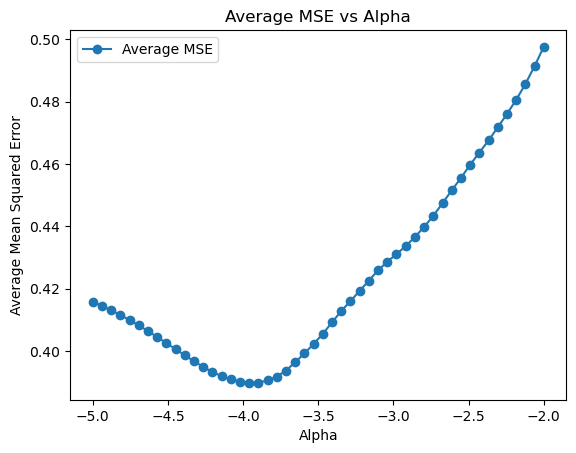

In [304]:
# Calculate the average MSE for each alpha
average_mse_dict = {alpha: np.mean(mse_values) for alpha, mse_values in mse_dict.items()}

# Plot the average MSE vs alpha
plt.plot(np.log10(list(average_mse_dict.keys())), list(average_mse_dict.values()), marker='o', linestyle='-', label='Average MSE')
plt.xlabel('Alpha')
plt.ylabel('Average Mean Squared Error')
plt.title('Average MSE vs Alpha')
plt.legend()
plt.savefig('MSE vs Alpha.png')
plt.show()


In [260]:
average_mse_df = pd.DataFrame(list(average_mse_dict.items()), columns=['Alpha', 'Average MSE'])

In [262]:
average_mse_df.to_csv('lasso_and_MSE.csv', index=False)  

In [252]:
min_mse_alpha = min(average_mse_dict, key=average_mse_dict.get)
min_mse_value = average_mse_dict[min_mse_alpha]

In [257]:
min_mse_alpha

0.00010985411419875583

In [282]:
lasso_model_final = Lasso(alpha=min_mse_alpha)
lasso_model_final.fit(X_train, y_train)


# y_test_pred = lasso_model_final.predict(y)

# # Evaluate the performance on the holdout set
# mse_holdout = mean_squared_error(y_holdout, y_holdout_pred)
# print(f'Mean Squared Error on Holdout Set: {mse_holdout}')

# # If you want to get the coefficients of the features selected by Lasso
# lasso_coefs = lasso_model_final.coef_
# np.set_printoptions(precision=4)
# # Now print the coefficients
# print(lasso_coefs)

Lasso(alpha=0.00010985411419875583)

In [285]:
len(lasso_model_final.coef_)

1574

In [287]:
len(data_columns)

1574

In [288]:
lasso_coefs = lasso_model_final.coef_

In [289]:
coefs_df = pd.DataFrame({'Feature': data_columns, 'Coefficient': lasso_coefs})

In [292]:
coefs_df_filtered = coefs_df[coefs_df['Coefficient'] != 0]

In [298]:
coefs_df_filtered_sorted = coefs_df_filtered.reindex(coefs_df_filtered['Coefficient'].sort_values(ascending=False).index)

In [300]:
#Filter dev and pub to see which features have importance outside of those
coefs_df_filtered_sorted_filtered = coefs_df_filtered_sorted[~coefs_df_filtered_sorted['Feature'].str.contains('dev_|pub_')]
print(coefs_df_filtered_sorted_filtered)

                                Feature  Coefficient
1519                  tag_Voice Control     0.834572
1240                        tag_Archery     0.687734
1254                           tag_Pool     0.537271
1563                      ln.curatorsp1     0.472548
778                          tag_Tennis     0.399504
60           Tracked Controller Support     0.382919
722                           tag_Tanks     0.361853
781                tag_Social Deduction     0.359816
907                       tag_Wrestling     0.315037
150                        tag_Moddable     0.298578
607                       tag_Space Sim     0.291112
92                   genre_Early Access     0.287278
1566                   ln.totDLCPricep1     0.284150
218                      tag_Soundtrack     0.271466
1093                         tag_Horses     0.271337
355                            tag_LEGO     0.269747
879                     tag_Time Attack     0.252851
688           tag_Massively Multiplayer     0.

In [301]:
coefs_df_filtered_sorted_filtered.shape

(368, 2)